<a href="https://colab.research.google.com/github/ShotaYamasaki/git_git/blob/master/%E3%80%90%E9%A7%85%E3%81%A1%E3%81%8B%E3%80%91%E3%82%A4%E3%83%99%E3%83%B3%E3%83%88%E5%88%86%E6%9E%90%E6%B1%8E%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# コード、CSVファイルがあるディレクトリ名に変更
%cd "/content/drive/MyDrive/駅ちか"

/content/drive/MyDrive/駅ちか


In [ ]:
# ライブラリのインストール
!pip install japanize_matplotlib
!pip install -U  ydata-profiling

In [ ]:
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import japanize_matplotlib
import pandas as pd
import polars as pl
import seaborn as sns
from urllib.parse import urlparse, parse_qs
from collections import Counter
from ydata_profiling import ProfileReport

%matplotlib inline
pd.options.mode.copy_on_write = True
# matplotlibの日本語書式を設定
plt.rcParams['font.family'] = 'IPAexGothic'

### テーブルデータ抽出(容易に実行しない)

In [ ]:
#!pip install google-cloud-bigquery

In [ ]:
"""
from google.colab import auth  # Google Colabで認証を行うためのモジュール
from google.cloud import bigquery  # Google CloudのBigQueryサービスを利用するためのライブラリ
from google.cloud import bigquery_storage
"""

'\nfrom google.colab import auth  # Google Colabで認証を行うためのモジュール\nfrom google.cloud import bigquery  # Google CloudのBigQueryサービスを利用するためのライブラリ\nfrom google.cloud import bigquery_storage\n'

In [ ]:
# Google Colabでの認証
#auth.authenticate_user()

# BigQueryクライアントの初期化
#client = bigquery.Client(project="acl-analysis-dm-ek")

In [ ]:
query = f'''
SELECT
  event_date,
  CAST(event_time AS DATETIME) AS event_time,
  event_timestamp,
  CAST(user_pseudo_id AS FLOAT64) AS user_pseudo_id,
  user_session_id,
  ga_session_number,
  event_name,
  page_title,
  page_location,
  page_referrer,
  content_group,
  content_group_shopdetail,
  content_group_mypage,
  content_group_hotel,
  shop_name,
  shop_id,
  prefecture,
  area,
  page_city,
  biz,
  girl_name,
  girl_id,
  page_genre,
  page_genre_id,
  page_girl_genre,
  page_girl_genre_id,
  member_id,
  member_age,
  member_area,
  member_work,
  review_type,
  review_playplace,
  PARSE_DATE("%Y-%m-%d", review_visitdate) AS review_visitdate, -- 口コミ：遊んだ日付
  review_expense,
  review_satisfaction,
  review_mygirl,
  review_myshop,
  session_traffic_source_last_click_source,
  session_traffic_source_last_click_medium,
  session_traffic_source_default_channel_group
FROM `acl-analysis-dm-ek.analysis_datamart.ga4_rd_ek`
WHERE  event_date = "2024-12-28"
AND event_name IN ("session_start", "page_view", "tel_tap", "reserve_tap", "add_to_watch", "add_to_mygirl", "add_to_myshop", "post_review")
'''

In [ ]:
# クエリを実行
#query_job = client.query(query)
#results = query_job.result().to_dataframe()

In [ ]:
# 結果をデータフレームに変換
#df = pd.DataFrame(results)
#df.to_csv('eki_test.csv')

## Pandas

### データフレームの作成

In [ ]:
# 適宜CSVファイル名は変更してください
df = pd.read_csv('eki_test.csv', index_col=0, low_memory=False)

In [ ]:
# データの情報を簡易的に確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2489282 entries, 0 to 2489281
Data columns (total 40 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   event_date                                    object 
 1   event_time                                    object 
 2   event_timestamp                               int64  
 3   user_pseudo_id                                float64
 4   user_session_id                               object 
 5   ga_session_number                             int64  
 6   event_name                                    object 
 7   page_title                                    object 
 8   page_location                                 object 
 9   page_referrer                                 object 
 10  content_group                                 object 
 11  content_group_shopdetail                      object 
 12  content_group_mypage                          object 
 13  co

In [ ]:
# event_timestampから日付、日時へ変換
df['event_time'] = pd.to_datetime(df['event_timestamp'], format='%Y-%m-%d %H:%M:%S').dt.floor('s')

# date型への変換
df['review_visitdate'] = pd.to_datetime(df['review_visitdate'], format='%Y-%m-%d')
# ↓event_dateカラム取得の場合使用
#df['event_date'] = pd.to_datetime(df['event_date'], format='%Y-%m-%d')
# ↓event_dateカラム取得の場合使用
# 秒以下の丸め込み
# df['event_time'] = pd.to_datetime(df['event_time']).dt.floor('s')

# 型変換
df = df.astype({'review_satisfaction': 'float32', 'member_age': 'Int64'})

In [ ]:
# カテゴリ型に変換
target = ['object', 'string', 'int64', 'float64']

for col in df.select_dtypes(include=target).columns:
    if df[col].nunique() / len(df[col]) < 0.5:  # ユニーク値が50%未満の場合
        df[col] = df[col].astype('category')

In [ ]:
# 重複行の削除
print(f'テーブルデータ内行数{df.shape[0]}')
print(f'重複行数{df.duplicated(keep=False).sum()}')
df = df.drop_duplicates().reset_index(drop=True)
print(f'重複削除後のテーブルデータ内行数{df.shape[0]}')

テーブルデータ内行数2489282
重複行数18
重複削除後のテーブルデータ内行数2489273


In [ ]:
# データの情報を簡易的に確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2489273 entries, 0 to 2489272
Data columns (total 40 columns):
 #   Column                                        Dtype         
---  ------                                        -----         
 0   event_date                                    datetime64[ns]
 1   event_time                                    datetime64[ns]
 2   event_timestamp                               int64         
 3   user_pseudo_id                                category      
 4   user_session_id                               category      
 5   ga_session_number                             category      
 6   event_name                                    category      
 7   page_title                                    category      
 8   page_location                                 category      
 9   page_referrer                                 category      
 10  content_group                                 category      
 11  content_group_shopdetail

In [ ]:
# データの概要把握
profile = ProfileReport(df, title="Profiling Report", minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


 18%|█▊        | 7/40 [00:10<00:36,  1.11s/it]

### 各指標の算出

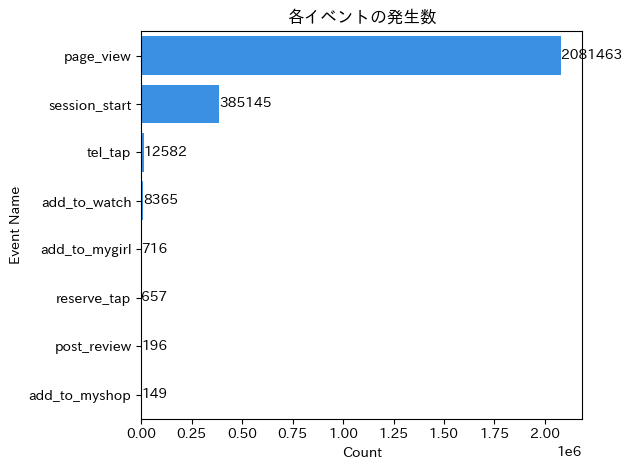

In [ ]:
# event_name の出現回数を集計し、降順にソートしてカテゴリの順序を取得
event_order = df["event_name"].value_counts().index

# countplot でバー plot を描画 (横向き、降順)
ax = sns.countplot(y="event_name", data=df, order=event_order, color="dodgerblue")

# 各バーの横に実数を表示
for p in ax.patches:
    # get_width() は横軸の値 (ここではカウント)
    # get_y() は縦軸の値 (ここではカテゴリの位置)
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center')

plt.xlabel("Count") # x軸とy軸のラベルを交換
plt.ylabel("Event Name")
plt.title("各イベントの発生数")
plt.tight_layout()
plt.show()

In [ ]:
event_dict = {
    'tel_tap': 'CV',
    'reserve_tap': 'CV',
    'page_view': 'PV',
    'add_to_watch': 'みたよ',
    'add_to_mygirl': 'マイガール',
    'add_to_myshop': 'マイショップ',
    'post_review': '口コミ投稿'
}

In [ ]:
def event_counts(event_list):
  for i in range(len(event_list)):
    # 1. フィルタリング
    df_temp = df[df['event_name'].isin(event_list[i])]

    # 2. 全イベント数
    total_event_count = df_temp.shape[0]

    # 3. イベントセッション数
    event_session_counts = df_temp['user_session_id'].nunique()

    # 4. 各セッションごとのイベント数
    session_per_event_counts = df_temp.groupby('user_session_id', observed=True).size().rename('event_count')

    # 5. イベント数が0のセッションを含める
    event_counts_full = pd.Series(0, index=df['user_session_id'].unique())
    event_counts_full.update(session_per_event_counts)

    # 6. 最頻値と統計量
    event_mode = event_counts_full.mode()[0]
    event_stats = event_counts_full.describe()

    # 7. 結果表示
    if event_list[i] == ['tel_tap', 'reserve_tap']:
        # 全体のセッション数
        session_counts = df['user_session_id'].nunique()

        # CVセッション数とCV率
        cv_session_counts = df_temp['user_session_id'].nunique()
        cvr = cv_session_counts / session_counts * 100

        print(f'セッション数: {session_counts}')
        print(f'CVセッション数: {cv_session_counts}')
        print(f'CV率: {cvr:.2f}%')
        print(f'全CV数: {total_event_count}')
        print(f'1セッションのCV数の最頻値: {event_mode}')
        print(f'1セッションのCV数の統計量:\n{event_stats}')
        print("==========================================")
    else:
        print(f'{event_dict[event_list[i][0]]}セッション数: {event_session_counts}')
        print(f'全{event_dict[event_list[i][0]]}数: {total_event_count}')
        print(f'1セッションの{event_dict[event_list[i][0]]}数の最頻値: {event_mode}')
        print(f'1セッションの{event_dict[event_list[i][0]]}数の統計量:\n{event_stats}')
        print("==========================================")

#### CV

In [ ]:
# 各イベントの実数、統計量の算出
cv_event_list = [['tel_tap', 'reserve_tap']]

event_counts(cv_event_list)

セッション数: 394229
CVセッション数: 7553
CV率: 1.92%
全CV数: 13239
1セッションのCV数の最頻値: 0
1セッションのCV数の統計量:
count    394229.000000
mean          0.033582
std           0.356119
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          47.000000
dtype: float64


In [ ]:
df_cv = df[df['event_name'].isin(['tel_tap', 'reserve_tap'])]

<ipython-input-16-447eed0c1c22>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cv_event_counts = df_cv.groupby([df_cv['event_date'].dt.to_period("D"), 'event_name']).size().unstack(fill_value=0)


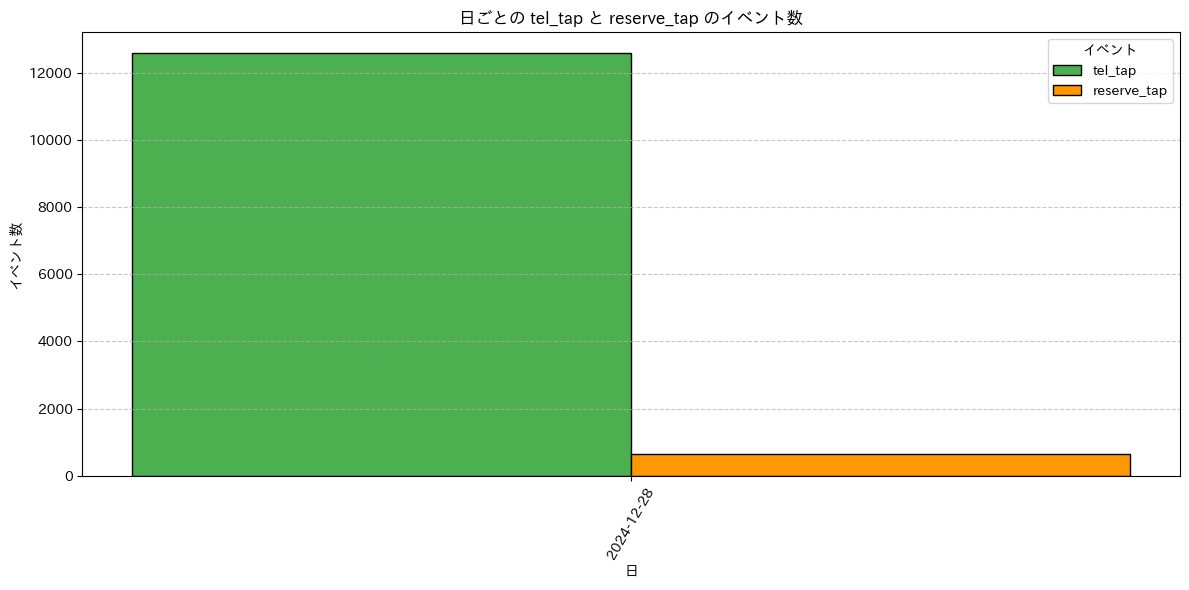

In [ ]:
# 日ごと、イベントごとにカウント
cv_event_counts = df_cv.groupby([df_cv['event_time'].dt.to_period("D"), 'event_name']).size().unstack(fill_value=0)

# 棒グラフを作成（Matplotlib直接使用）
plt.figure(figsize=(12, 6))

# バーの位置と幅
x = np.arange(len(cv_event_counts))  # 日数分のインデックス
width = 0.35  # バーの幅（横並び）

# tel_tapとreserve_tapのバーを描画
plt.bar(x - width/2, cv_event_counts['tel_tap'], width, color='#4CAF50', edgecolor='black', label='tel_tap')
plt.bar(x + width/2, cv_event_counts['reserve_tap'], width, color='#FF9800', edgecolor='black', label='reserve_tap')

# グラフ設定
plt.title('日ごとの tel_tap と reserve_tap のイベント数')
plt.xlabel('日')
plt.ylabel('イベント数')
plt.xticks(x, cv_event_counts.index, rotation=60)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='イベント')
plt.tight_layout()
plt.show()

In [ ]:
# 月ごとに user_pseudo_id のユニークな数をカウント
cv_counts = df_cv.groupby(df_cv['event_time'].dt.to_period("D")).size()

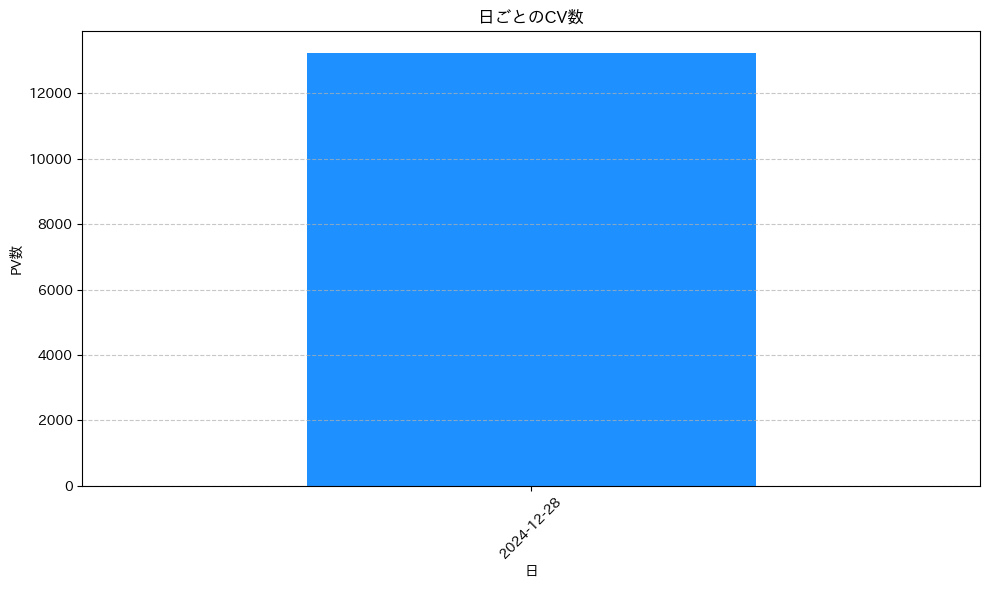

In [ ]:
# 棒グラフを作成
plt.figure(figsize=(10, 6))
cv_counts.plot(kind='bar', color='dodgerblue')
plt.title('日ごとのCV数')
plt.xlabel('日')
plt.ylabel('PV数')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### PV

In [ ]:
# 各イベントの実数、統計量の算出
pv_event_list = [['page_view']]

event_counts(pv_event_list)

PVセッション数: 389656
全PV数: 2081463
1セッションのPV数の最頻値: 1
1セッションのPV数の統計量:
count    394229.000000
mean          5.279832
std          13.022119
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        1880.000000
dtype: float64


In [ ]:
# 仮にデータフレームとpv_contentを以下のように作成
df_pv = df[df['event_name'] == 'page_view']

In [ ]:
# 月ごとに user_pseudo_id のユニークな数をカウント
pv_counts = df_pv.groupby(df_pv['event_time'].dt.to_period("D")).size()

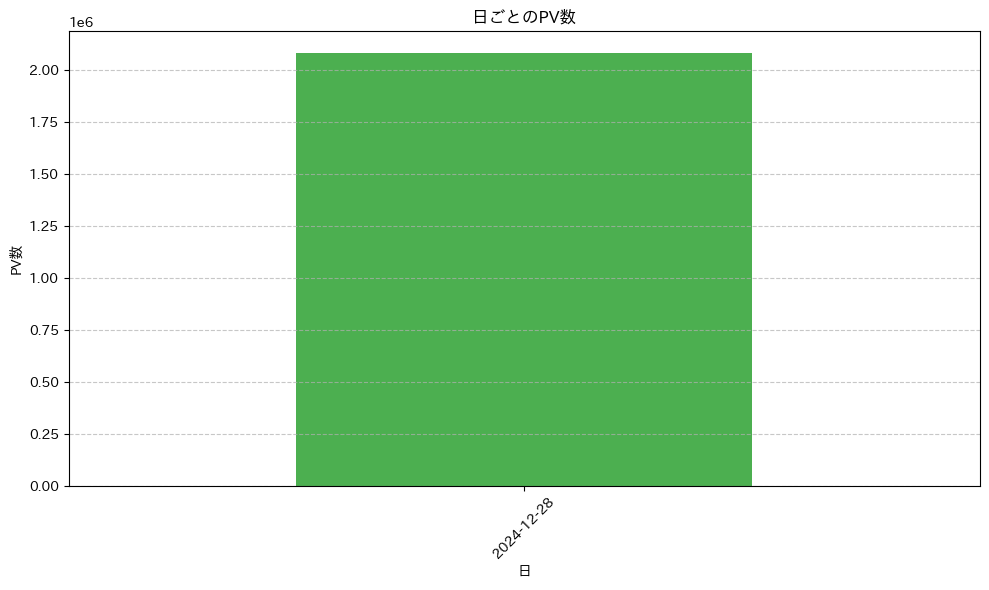

In [ ]:
# 棒グラフを作成
plt.figure(figsize=(10, 6))
pv_counts.plot(kind='bar', color='#4CAF50')
plt.title('日ごとのPV数')
plt.xlabel('日')
plt.ylabel('PV数')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
pv_content = df_pv['content_group'].value_counts().sort_values(ascending=False)

print(pv_content)

content_group
駅ちか_女の子詳細トップ          717112
駅ちか_店舗詳細トップ           287774
駅ちか_店舗詳細出勤一覧          190958
発エリア店舗ランキング           183177
駅ちか_店舗詳細在籍一覧           66589
                       ...  
運営者情報                      6
都道府県価格帯一覧                  5
広告掲載について                   4
駅・スポット即イク女の子ジャンル一覧         4
リンクについて                    2
Name: count, Length: 141, dtype: int64


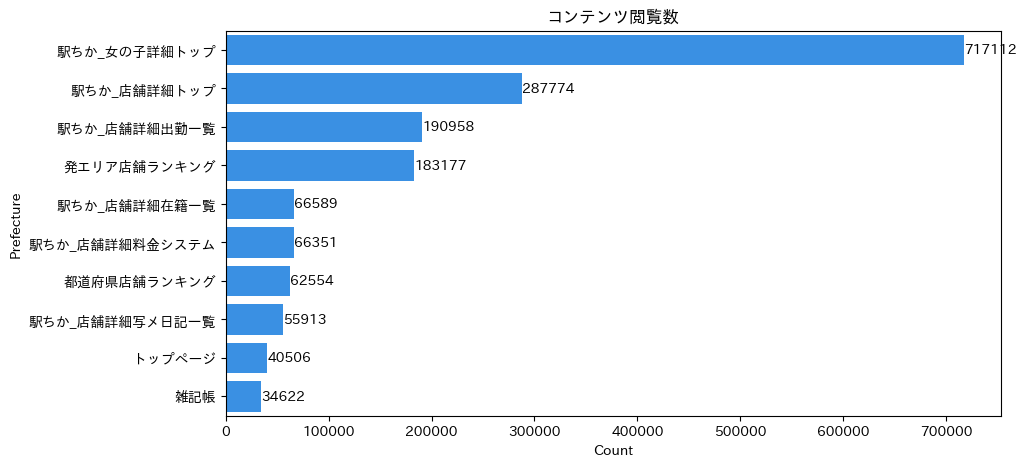

In [ ]:
plt.figure(figsize=(10, 5))

# countplot でバー plot を描画 (横向き、降順)
ax_ct = sns.countplot(y="content_group", data=df_pv, order=pv_content.index[:10], color="dodgerblue")

# 各バーの横に実数を表示
for p in ax_ct.patches:
    # get_width() は横軸の値 (ここではカウント)
    # get_y() は縦軸の値 (ここではカテゴリの位置)
    ax_ct.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center')

plt.xlabel("Count") # x軸とy軸のラベルを交換
plt.ylabel("Prefecture")
plt.title("コンテンツ閲覧数")
plt.show()

In [ ]:
# 仮にデータフレームとpv_contentを以下のように作成
# （実際には質問のコードでpv_contentが計算済みと仮定）
# df = pd.DataFrame({...}) # 実際のデータフレーム
pv_prefecture = df_pv['prefecture'].value_counts().sort_values(ascending=False)

print(pv_prefecture)

prefecture
東京都     327145
福岡県     277783
神奈川県    227719
大阪府     141319
愛知県      88169
千葉県      67084
埼玉県      64940
茨城県      47054
北海道      42315
兵庫県      42219
熊本県      40470
宮城県      37250
広島県      36206
岡山県      32066
福島県      30165
群馬県      27380
静岡県      26768
栃木県      25821
愛媛県      19143
長野県      17980
岐阜県      17950
山口県      17856
青森県      17384
京都府      17074
岩手県      16495
沖縄県      15773
鹿児島県     14536
佐賀県      14472
滋賀県      14238
新潟県      13118
三重県      13082
秋田県      12986
石川県      12678
宮崎県      10426
香川県       9758
奈良県       9633
富山県       9572
和歌山県      9442
山形県       8758
大分県       7963
長崎県       7736
山梨県       6123
島根県       6048
鳥取県       6014
高知県       5305
福井県       4824
徳島県       4554
Name: count, dtype: int64


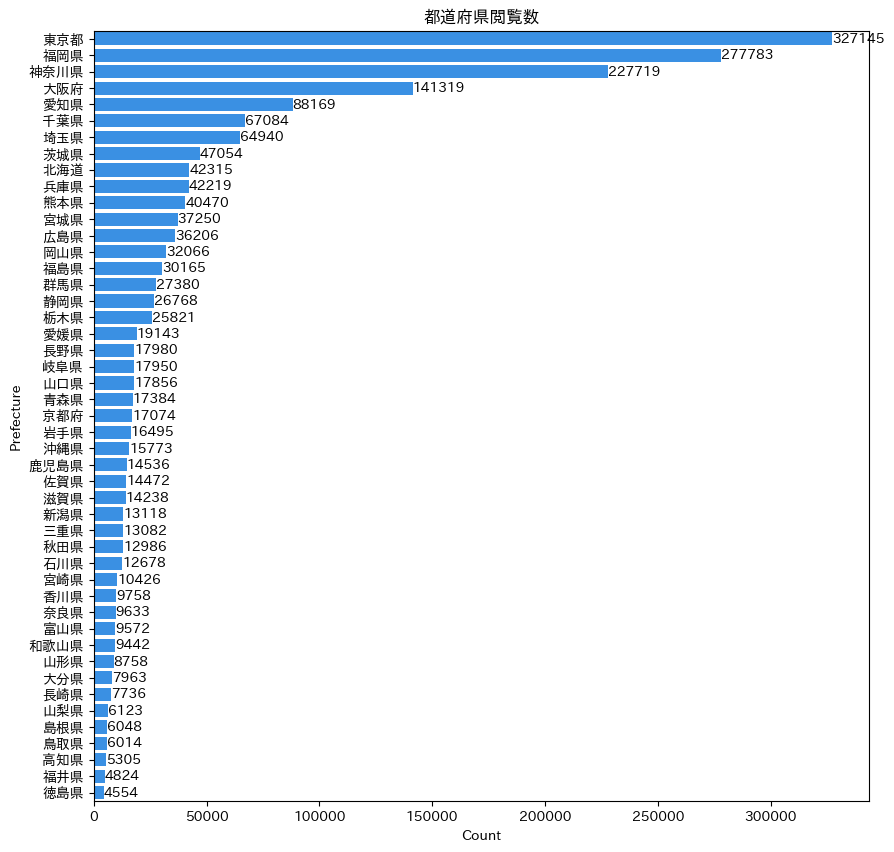

In [ ]:
plt.figure(figsize=(10, 10))

# countplot でバー plot を描画 (横向き、降順)
ax_pf = sns.countplot(y="prefecture", data=df_pv, order=pv_prefecture.index, color="dodgerblue")

# 各バーの横に実数を表示
for p in ax_pf.patches:
    # get_width() は横軸の値 (ここではカウント)
    # get_y() は縦軸の値 (ここではカテゴリの位置)
    ax_pf.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center')

plt.xlabel("Count") # x軸とy軸のラベルを交換
plt.ylabel("Prefecture")
plt.title("都道府県閲覧数")
plt.show()

#### 会員情報

In [ ]:
# 会員行動の基本数値
member_event_list = [['add_to_watch'], ['add_to_mygirl'], ['add_to_myshop'], ['post_review']]

event_counts(member_event_list)

みたよセッション数: 1858
全みたよ数: 8365
1セッションのみたよ数の最頻値: 0
1セッションのみたよ数の統計量:
count    394229.000000
mean          0.021219
std           0.914509
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         200.000000
dtype: float64
マイガールセッション数: 372
全マイガール数: 716
1セッションのマイガール数の最頻値: 0
1セッションのマイガール数の統計量:
count    394229.000000
mean          0.001816
std           0.090806
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          18.000000
dtype: float64
マイショップセッション数: 80
全マイショップ数: 149
1セッションのマイショップ数の最頻値: 0
1セッションのマイショップ数の統計量:
count    394229.000000
mean          0.000378
std           0.039108
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.000000
dtype: float64
口コミ投稿セッション数: 159
全口コミ投稿数: 196
1セッションの口コミ投稿数の最頻値: 0
1セッションの口コミ投稿数の統計量:
count    394229.000000
mean          0.000497
std           0.027947
min           0.000000
25%           0.000000
50%        

In [ ]:
# 日ごとに会員行動をカウント
watch_counts = df[df['event_name'] == 'add_to_watch'].groupby(df['event_time'].dt.to_period("D")).size()
mygirl_counts = df[df['event_name'] == 'add_to_mygirl'].groupby(df['event_time'].dt.to_period("D")).size()
myshop_counts = df[df['event_name'] == 'add_to_myshop'].groupby(df['event_time'].dt.to_period("D")).size()
review_counts = df[df['event_name'] == 'post_review'].groupby(df['event_time'].dt.to_period("D")).size()

print(watch_counts)
print(mygirl_counts)
print(myshop_counts)
print(review_counts)

event_date
2024-12-28    8365
Freq: D, dtype: int64
event_date
2024-12-28    716
Freq: D, dtype: int64
event_date
2024-12-28    149
Freq: D, dtype: int64
event_date
2024-12-28    196
Freq: D, dtype: int64


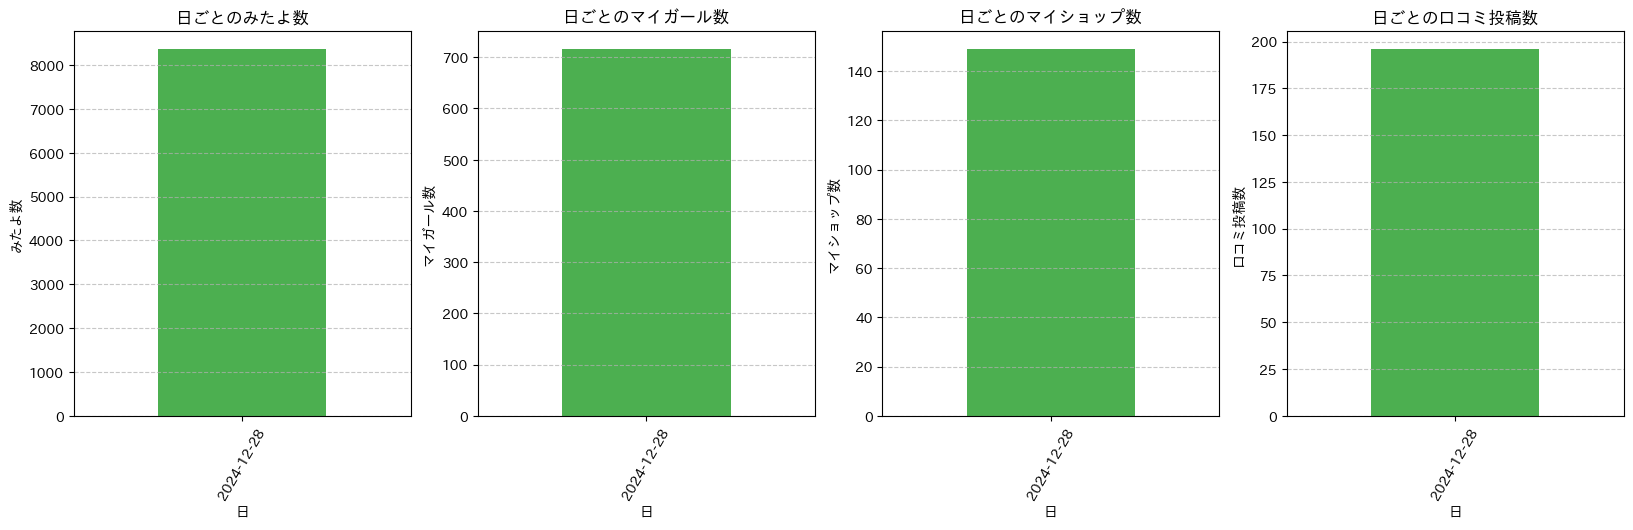

In [ ]:
# 会員行動
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharex=False)

# みたよ
watch_counts.plot(kind='bar', color='#4CAF50', ax=ax1)
ax1.set_xlabel('日')
ax1.set_ylabel('みたよ数')
ax1.set_title('日ごとのみたよ数')
ax1.tick_params(axis='x', rotation=60)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# マイガール
mygirl_counts.plot(kind='bar', color='#4CAF50', ax=ax2)
ax2.set_xlabel('日')
ax2.set_ylabel('マイガール数')
ax2.set_title('日ごとのマイガール数')
ax2.tick_params(axis='x', rotation=60)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# マイショップ
myshop_counts.plot(kind='bar', color='#4CAF50', ax=ax3)
ax3.set_xlabel('日')
ax3.set_ylabel('マイショップ数')
ax3.set_title('日ごとのマイショップ数')
ax3.tick_params(axis='x', rotation=60)
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# 口コミ投稿
review_counts.plot(kind='bar', color='#4CAF50', ax=ax4)
ax4.set_xlabel('日')
ax4.set_ylabel('口コミ投稿数')
ax4.set_title('日ごとの口コミ投稿数')
ax4.tick_params(axis='x', rotation=60)
ax4.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
# 会員情報
df_unique = df.sort_values('event_time').groupby('user_pseudo_id')[['member_age', 'member_area', 'member_work']].last().reset_index()
# 会員の年齢
member_age = df_unique['member_age'].value_counts().sort_values(ascending=False)
#会員の職業
member_work = df_unique['member_work'].value_counts().sort_values(ascending=False)
#会員の所在地
member_area = df_unique['member_area'].value_counts().sort_values(ascending=False)

print(member_age)
print(f"\n{member_work}")
print(f"\n{member_area}")

<ipython-input-37-a657a9f19b70>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_unique = df.sort_values('event_time').groupby('user_pseudo_id')[['member_age', 'member_area', 'member_work']].last().reset_index()


member_age
44     756
43     425
39     380
46     356
49     355
      ... 
116      1
120      1
118      1
117      1
121      1
Name: count, Length: 85, dtype: int64

member_work
会社員      8802
その他      1584
自営業      1238
フリーター     267
学生        211
派遣社員      145
Name: count, dtype: int64

member_area
福岡県     2927
神奈川県    1966
東京都     1846
大阪府      716
千葉県      471
埼玉県      404
愛知県      398
熊本県      352
茨城県      285
北海道      279
兵庫県      183
広島県      181
福島県      143
宮城県      138
佐賀県      134
山口県      119
静岡県      114
鹿児島県     109
栃木県      102
岡山県      100
群馬県       84
青森県       80
京都府       76
長崎県       72
和歌山県      67
岐阜県       65
愛媛県       64
沖縄県       61
山形県       60
長野県       60
宮崎県       56
石川県       51
滋賀県       51
三重県       49
富山県       47
奈良県       42
新潟県       41
大分県       37
山梨県       36
岩手県       35
鳥取県       35
香川県       31
秋田県       25
島根県       20
福井県       17
徳島県       12
高知県        6
Name: count, dtype: int64


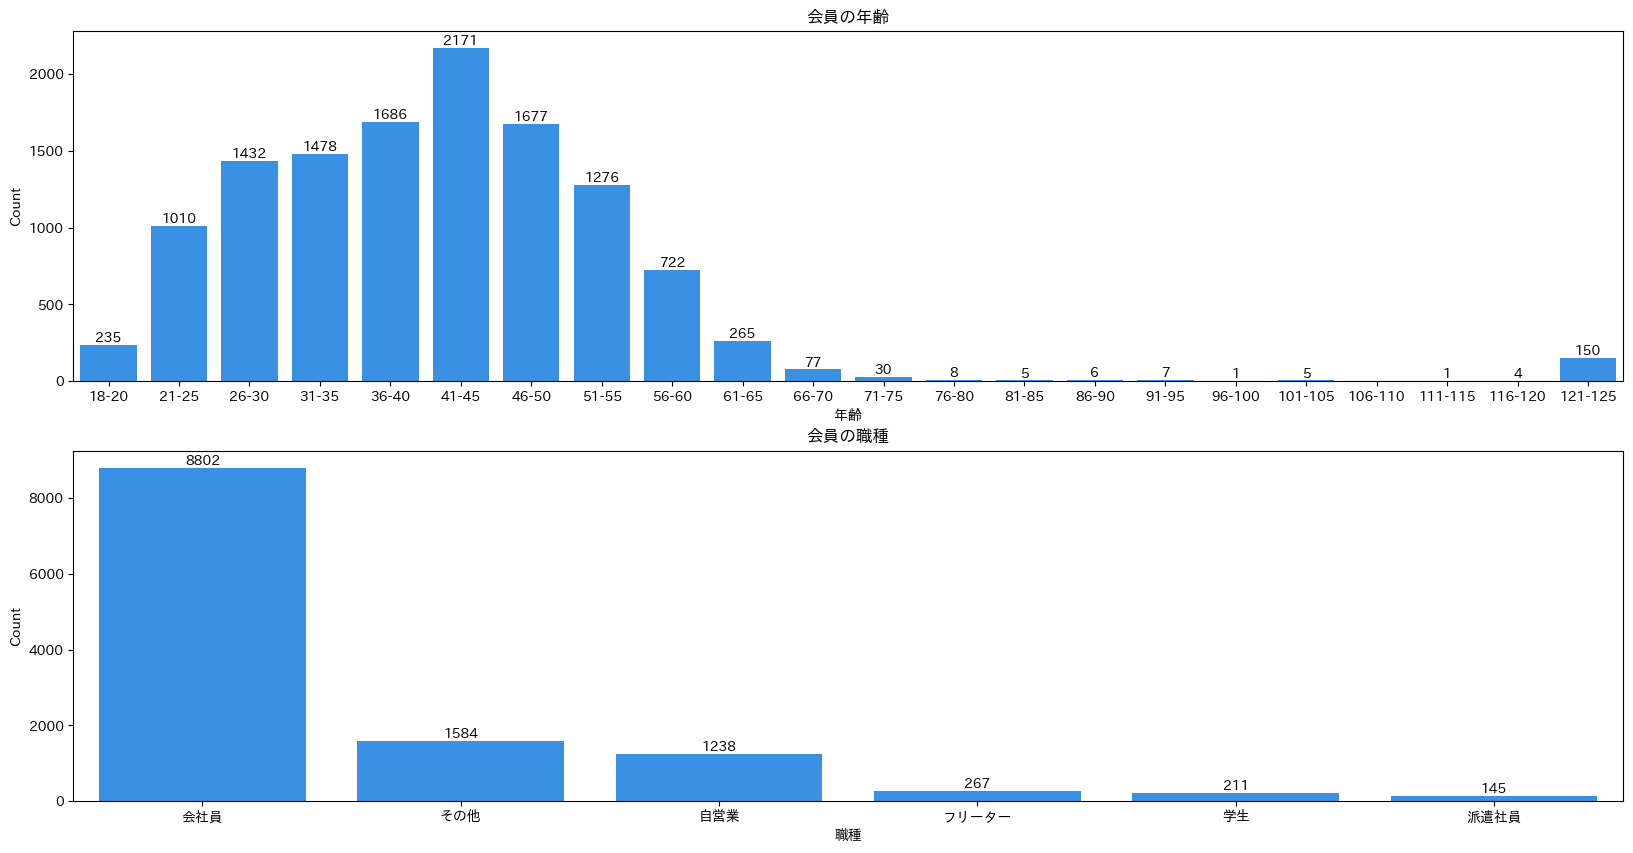

In [ ]:
# 会員の年齢総の分布
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)

# 年齢を指定のビンにグループ化（18-20歳、21歳以降は5歳刻みで125歳まで）
bins = [18, 21] + list(range(26, 127, 5))  # [18, 21, 26, 31, ..., 121, 126]
labels = ["18-20"] + [f"{i}-{i+4}" for i in range(21, 122, 5)]  # ["18-20", "21-25", "26-30", ..., "121-125"]
df_unique['age_group'] = pd.cut(df_unique['member_age'], bins=bins, labels=labels, include_lowest=True)
# countplotで縦向きのバープロットを描画（データに登場する年齢グループのみ、年齢順）
sns.countplot(x="age_group", data=df_unique, order=labels, color="dodgerblue", ax=ax1)
"""
# データに登場する年齢のみを抽出し、年齢順にソート（NaNは除外）
age_order = sorted(df['member_age'].dropna().unique())
sns.countplot(x="member_age", data=df, order=age_order, color="dodgerblue", ax=ax1)
"""
# 各バーの上に実数を表示
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom')

ax1.set_ylabel("Count")
ax1.set_xlabel("年齢")
ax1.set_title("会員の年齢")


# 職種の分布
sns.countplot(x="member_work", data=df_unique, order=member_work.index, color="dodgerblue", ax=ax2)
# 各バーの上に実数を表示
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom')
ax2.set_ylabel("Count")
ax2.set_xlabel("職種")
ax2.set_title("会員の職種")
plt.show()

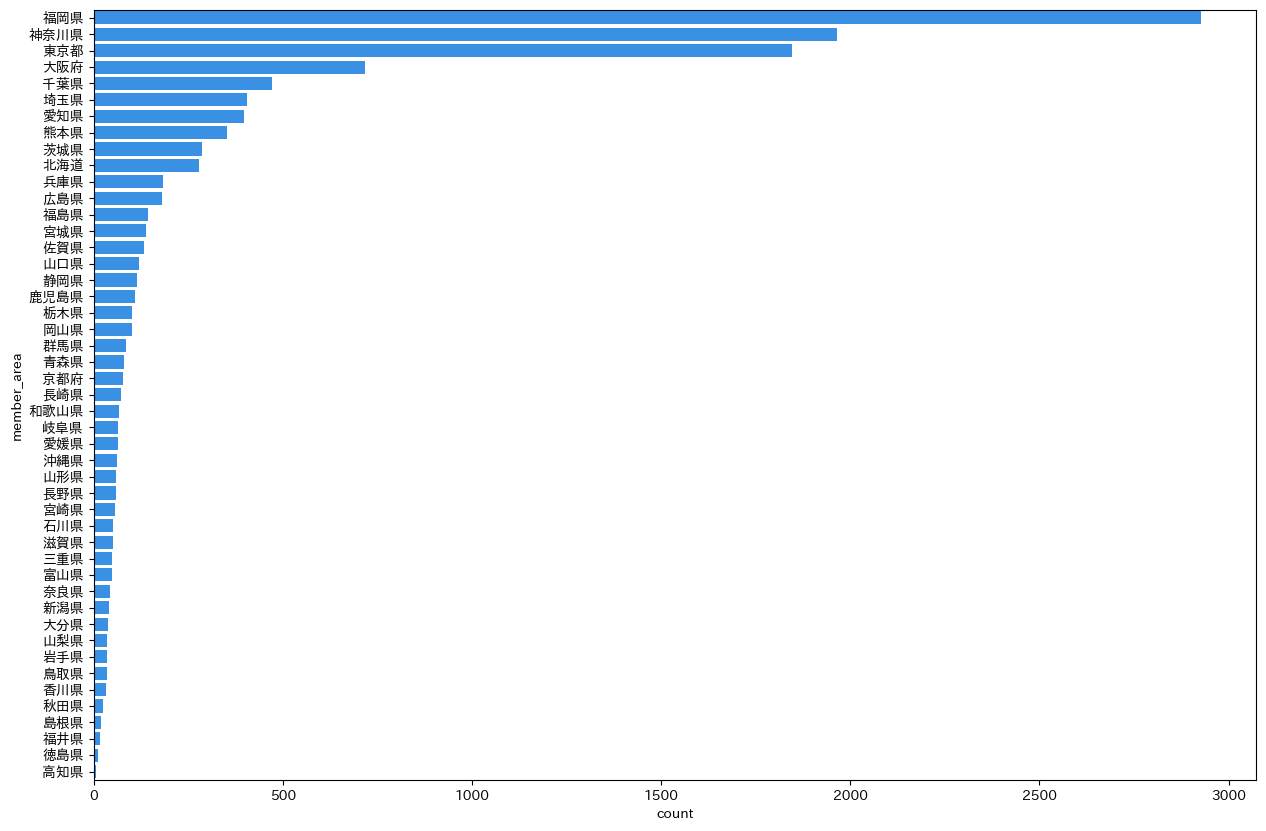

In [ ]:
# 会員の所在地
fig = plt.figure(figsize=(15, 10))
sns.countplot(y="member_area", data=df_unique, order=member_area.index, color="dodgerblue")

# 各バーの横に実数を表示
for p in ax.patches:
    # get_width() は横軸の値 (ここではカウント)
    # get_y() は縦軸の値 (ここではカテゴリの位置)
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center')

ax.set_xlabel("Count")
ax.set_ylabel("都道府県")
ax.set_title("会員の所在地")
plt.show()

#### 新規ユーザー

In [ ]:
# 新規ユーザー数
new_users = df[df['ga_session_number'] == 1]['user_pseudo_id'].unique()
user_counts = df['user_pseudo_id'].nunique()
print(f'総ユーザー数: {user_counts}')
print(f'新規ユーザー数: {len(new_users)}')
print(f'新規ユーザーの割合: {len(new_users) / user_counts * 100: .2f}%')
# 新規ユーザーのsession_idを取得
new_user_session_ids = df[df["user_pseudo_id"].isin(new_users)]['user_session_id'].unique()
# 初回訪問セッション（ga_session_number == 1）の抽出
new_user_sessions = df[(df['user_session_id'].isin(new_user_session_ids)) & (df['ga_session_number'] == 1)]

"""
event_timestampを基準にソートし、最初のレコードを保持
同じuser_pseudo_idでもga_session_number=1が複数確認されていることがあるため
ga_session_number=1のセッションを時系列順に並べ真の初回訪問のセッション（new_user_sessions_unique）を抽出する
"""
# 初回訪問セッションをuser_pseudo_id, event_timestampで昇順（時系列順）に並び替え
new_user_sessions_sorted = new_user_sessions.sort_values(by=['user_pseudo_id', 'event_timestamp'])
# 並び替えた中でuser_pseudo_idの重複を最初のセッションだけ残るように削除
new_user_sessions_unique = new_user_sessions_sorted.drop_duplicates(subset='user_pseudo_id', keep='first')

総ユーザー数: 307374
新規ユーザー数: 167191
新規ユーザーの割合:  54.39%


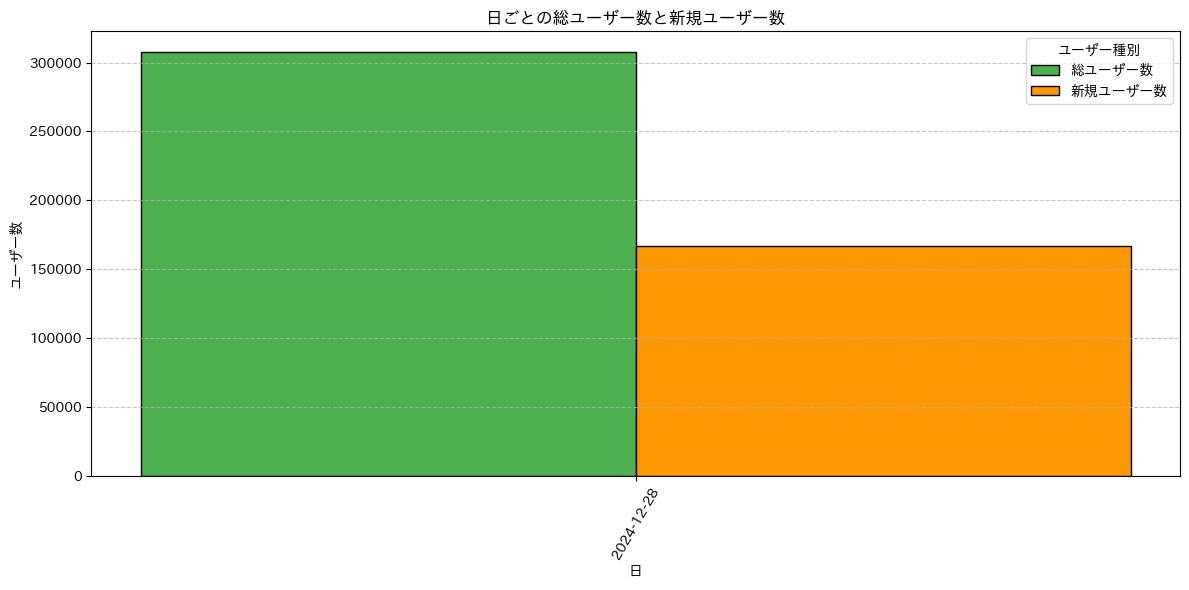

In [ ]:
# 1. 日ごとの総ユーザー数と新規ユーザー数を集計
# 総ユーザー数：日ごとのユニークなuser_pseudo_id
total_user_counts = df.groupby(df['event_time'].dt.to_period('D'))['user_pseudo_id'].nunique()

# 新規ユーザー数：new_user_sessions_uniqueから日ごとのユニークなuser_pseudo_id
new_user_counts = new_user_sessions_unique.groupby(new_user_sessions_unique['event_time'].dt.to_period('D'))['user_pseudo_id'].nunique()

# データフレームに結合
user_counts_df = pd.DataFrame({
    'total_users': total_user_counts,
    'new_users': new_user_counts
}).fillna(0).astype(int)  # 欠損値を0で埋め、整数型に

# 2. 棒グラフを作成（Matplotlib直接使用）
plt.figure(figsize=(12, 6))

# バーの位置と幅
x = np.arange(len(user_counts_df))  # 日数分のインデックス
width = 0.35  # バーの幅（横並び）

# 総ユーザー数と新規ユーザー数のバーを描画
plt.bar(x - width/2, user_counts_df['total_users'], width, color='#4CAF50', edgecolor='black', label='総ユーザー数')
plt.bar(x + width/2, user_counts_df['new_users'], width, color='#FF9800', edgecolor='black', label='新規ユーザー数')

# グラフ設定
plt.title('日ごとの総ユーザー数と新規ユーザー数')
plt.xlabel('日')
plt.ylabel('ユーザー数')
plt.xticks(x, user_counts_df.index, rotation=60)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='ユーザー種別')
plt.tight_layout()
plt.show()

#### LP

In [ ]:
# session_startnoデータフレーム
df_ss = df[df['event_name'] == 'session_start']

# LPの情報
lp_content = df_ss['content_group'].value_counts().sort_values(ascending=False)
lp_medium = df_ss['session_traffic_source_last_click_medium'].value_counts().sort_values(ascending=False)
lp_source = df_ss['session_traffic_source_last_click_source'].value_counts().sort_values(ascending=False)

print("\nlp_content:\n", lp_content)
print("\nlp_medium:\n", lp_medium)
print("\nlp_source:\n", lp_source)


lp_content:
 content_group
駅ちか_女の子詳細トップ          90735
発エリア店舗ランキング           74864
駅ちか_店舗詳細トップ           35456
都道府県店舗ランキング           22975
雑記帳                   20323
                      ...  
運営者情報                     0
都道府県価格帯一覧                 0
駅・スポット女の子ジャンルランキング        0
駅・スポット女の子一覧               0
駅・スポット店舗ジャンルランキング         0
Name: count, Length: 141, dtype: int64

lp_medium:
 session_traffic_source_last_click_medium
organic         172670
display         104855
referral         75586
(none)           26794
maps              3246
email             1338
social             611
game_content        34
(not set)            5
off_sampling         3
n2nsoft.com          2
zalo                 1
Name: count, dtype: int64

lp_source:
 session_traffic_source_last_click_source
google               130054
Razer                 96680
yahoo                 44436
(direct)              26794
widget                15111
                      ...  
majierogo.info            1
mail.ocn.jp        

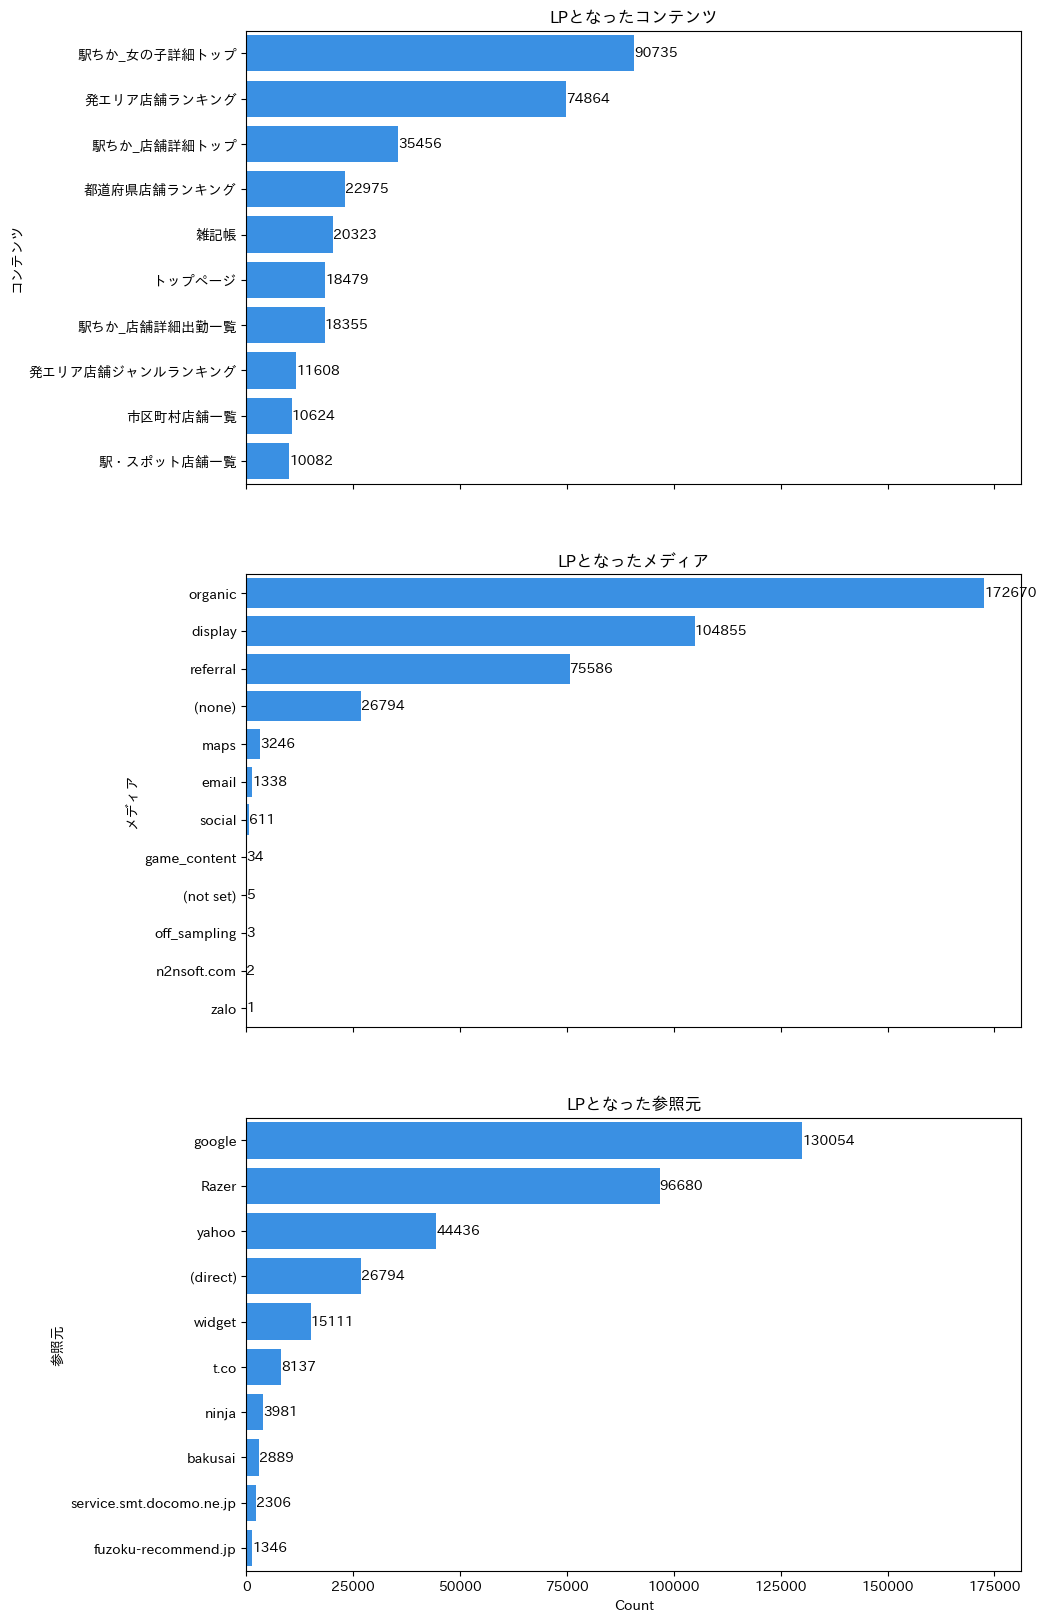

In [ ]:
# LPの情報
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20), sharex=True)

# countplot でバー plot を描画 (横向き、降順)
sns.countplot(y="content_group", data=df_ss, order=lp_content.index[:10], color="dodgerblue", ax=ax1)

# 各バーの横に実数を表示
for p in ax1.patches:
    # get_width() は横軸の値 (ここではカウント)
    # get_y() は縦軸の値 (ここではカテゴリの位置)
    ax1.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center')

ax1.set_xlabel("Count")
ax1.set_ylabel("コンテンツ")
ax1.set_title("LPとなったコンテンツ")

sns.countplot(y="session_traffic_source_last_click_medium", data=df_ss, order=lp_medium.index, color="dodgerblue", ax=ax2)

# 各バーの横に実数を表示
for p in ax2.patches:
    # get_width() は横軸の値 (ここではカウント)
    # get_y() は縦軸の値 (ここではカテゴリの位置)
    ax2.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center')

ax2.set_xlabel("Count")
ax2.set_ylabel("メディア")
ax2.set_title("LPとなったメディア")

sns.countplot(y="session_traffic_source_last_click_source", data=df_ss, order=lp_source.index[:10], color="dodgerblue", ax=ax3)

# 各バーの横に実数を表示
for p in ax3.patches:
    # get_width() は横軸の値 (ここではカウント)
    # get_y() は縦軸の値 (ここではカテゴリの位置)
    ax3.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center')

ax3.set_xlabel("Count")
ax3.set_ylabel("参照元")
ax3.set_title("LPとなった参照元")
plt.show()

# 以降は一旦使用しない

## 関数

In [ ]:
content_group_mypage_map = {
  "https://ranking-deli.jp/member/login/" : "マイページログイン",
  "https://ranking-deli.jp/member/info/" : "マイページトップ",
  "https://ranking-deli.jp/member/info/keep/shop/" : "キープ中のお店",
  "https://ranking-deli.jp/member/info/keep/girl/" : "キープ中の女の子",
  "https://ranking-deli.jp/member/telregister/" : "会員登録_電話番号を入力",
  "https://ranking-deli.jp/member/info/come/" : "キテね一覧",
  "https://ranking-deli.jp/member/info/magazine/" : "マガジン一覧",
  "https://ranking-deli.jp/member/info/myshop/" : "マイショップ一覧",
  "https://ranking-deli.jp/member/info/review/" : "口コミTOP",
  "https://ranking-deli.jp/member/info/review/register/" : "口コミを書く",
  "https://ranking-deli.jp/member/info/review/list/" : "投稿済み口コミ一覧",
  "https://ranking-deli.jp/member/info/browsinghistory/girl/" : "女の子の閲覧履歴",
  "https://ranking-deli.jp/member/info/browsinghistory/shop/" : "お店の閲覧履歴",
  "https://ranking-deli.jp/member/info/update/logininfo/" : "登録情報の更新",
  "https://ranking-deli.jp/member/info/mygirl/" : "マイガール一覧",
  "https://ranking-deli.jp/member/forget/password/" : "パスワードをお忘れの方",
  "https://ranking-deli.jp/member/info/campaign/cashback/win/" : "キャッシュバック当選",
  "https://ranking-deli.jp/member/info/magazine/platinum/" : "プラチナムマガジン一覧",
  "https://ranking-deli.jp/member/info/magazine/platinum/" : "プラチナムマガジン詳細",
  "https://ranking-deli.jp/member/info/magazine/news/" : "運営部マガジン一覧",
  "https://ranking-deli.jp/member/info/magazine/news/" : "運営部マガジン詳細",
  "https://ranking-deli.jp/member/info/contact/" : "お問い合わせ",
  "https://ranking-deli.jp/member/info/update/email/" : "メールアドレスの変更",
  "https://ranking-deli.jp/member/info/update/profile/" : "マイプロフィールの設定",
  "https://ranking-deli.jp/member/info/update/password/" : "パスワード変更",
  "https://ranking-deli.jp/member/info/update/tel/" : "電話番号の変更",
  "https://ranking-deli.jp/member/info/quit/" : "退会の手続き",
  "https://ranking-deli.jp/member/register/?mypageid=" : "会員登録_会員情報を入力",
  "https://ranking-deli.jp/member/info/myshop/edit/" : "マイショップ管理",
  "https://ranking-deli.jp/member/info/campaign/webreserves/win/" : "ネット予約当選",
  "https://ranking-deli.jp/member/register/retransmission/" : "確認メールの再送信",
  "https://ranking-deli.jp/member/info/campaign/cashback/" : "Other group",
  "https://ranking-deli.jp/member/info/missekichika/" : "Other group",
  "https://ranking-deli.jp/member/telregister/code/" : "Other group",
  "https://ranking-deli.jp/member/info/logout/" : "Other group"
}

In [ ]:
# content_group_mypageの内容を修正する関数
def map_page_location_to_content_group(page_location):
    # NaNまたは空の場合、Noneを返す（更新しない）
    if pd.isna(page_location) or not page_location:
        return

    # 文字列変換と余白除去
    page_location = str(page_location).strip()

    # https://ranking-deli.jp/member/ で始まるかチェック
    if not page_location.startswith("https://ranking-deli.jp/member/"):
        return

    # 完全一致を優先
    if page_location in content_group_mypage_map:
        return content_group_mypage_map[page_location]


    # ベースURL一致（最後の/以降を無視）
    base_urls = {
        "https://ranking-deli.jp/member/info/come/": "キテね一覧",
        "https://ranking-deli.jp/member/info/magazine/": "マガジン一覧",
        "https://ranking-deli.jp/member/info/myshop/": "マイショップ一覧",
        "https://ranking-deli.jp/member/info/mygirl/" : "マイガール一覧",
        "https://ranking-deli.jp/member/info/review/register/": "口コミを書く",
        "https://ranking-deli.jp/member/info/campaign/cashback/win/": "キャッシュバック当選",
        "https://ranking-deli.jp/member/info/contact/": "お問い合わせ",
        "https://ranking-deli.jp/member/info/myshop/edit/": "マイショップ管理"
    }
    for base_url, group in base_urls.items():
        if page_location.startswith(base_url):
            return group

    # 動的URL（/数値/）
    if page_location.startswith("https://ranking-deli.jp/member/info/magazine/platinum/") and page_location != "https://ranking-deli.jp/member/info/magazine/platinum/":
        return "プラチナムマガジン詳細"
    if page_location.startswith("https://ranking-deli.jp/member/info/magazine/news/") and page_location != "https://ranking-deli.jp/member/info/magazine/news/":
        return "運営部マガジン詳細"

    # デフォルト
    return "Other group"

In [ ]:
# last_click施工以前の流入元を修正する関数
def complement_media(df):
    df = df.copy()
    # ユーザーごとに前回のmediumを計算
    last_medium = df.groupby('user_pseudo_id')['collected_traffic_source_manual_medium'].ffill()

    # セッション開始時のイベントを特定
    is_session_start = df.groupby(['user_pseudo_id', 'user_session_id'])['event_time'].transform('min') == df['event_time']

    # セッション開始時のmediumがNoneの場合のみ、前回のlast_mediumで補完
    mask = is_session_start & df["collected_traffic_source_manual_medium"].apply(lambda x: pd.isna(x) and not x is None)

    # 前回のセッションのmediumで補完
    df.loc[mask, 'collected_traffic_source_manual_medium'] = last_medium[mask]

    # 補完後もNoneまたは空文字列の場合、corrected_mediumを(none)、sourceを(direct)に設定
    still_none_mask = mask & df["collected_traffic_source_manual_medium"].apply(lambda x: pd.isna(x) and not x is None)
    df.loc[still_none_mask, 'collected_traffic_source_manual_medium'] = '(none)'
    df.loc[still_none_mask, 'source'] = '(direct)'

    # 補完したcorrected_mediumをセッション内で伝播
    df['collected_traffic_source_manual_medium'] = df.groupby(['user_pseudo_id', 'user_session_id'])['collected_traffic_source_manual_medium'].transform('first')
    df.reset_index(drop=True, inplace=True)

    return df

## 型変換

In [ ]:
df_temp = df.copy()

In [ ]:
df_temp['review_satisfaction'] = df_temp['review_satisfaction'].fillna(-1).astype('float32')
df_temp.info()
#df_temp['review_satisfaction'] = df['review_satisfaction']

In [ ]:
# 重複行の削除
print(f'テーブルデータ内行数{df_temp.shape[0]}')
df_temp = df_temp.drop_duplicates().reset_index(drop=True)
print(f'重複行数{df_temp.duplicated(keep=False).sum()}')
print(f'重複削除後のテーブルデータ内行数{df_temp.shape[0]}')

In [ ]:
# データの型変換
for col in df_temp.select_dtypes(include=['object', 'string', 'float64', 'int64']).columns:
    if df_temp[col].nunique() / len(df_temp[col]) < 0.5:  # ユニーク値が50%未満の場合
        df_temp[col] = df_temp[col].astype('category')

In [ ]:
"""
# データフレームの概要把握
profile_v2 = ProfileReport(df_temp, title="Profiling Report V2")
profile_v2
"""

In [ ]:
# データ型の確認
df.info()

In [ ]:
df_temp.head()

In [ ]:
# データ型の確認
df_temp.info()

In [ ]:
df_temp['review_satisfaction'].value_counts()

In [ ]:
df = df_temp.copy()

## test

In [ ]:
df_temp = pd.read_csv('ek_shame1_member_250407_250421.csv', low_memory=False)

In [ ]:
df_temp.info()

In [ ]:
#df_temp['event_time'] = pd.to_datetime(df_temp['event_time'])
df_temp['event_date'] = pd.to_datetime(df_temp['event_date'], format='%Y%m%d')

In [ ]:
# 月ごとに user_pseudo_id のユニークな数をカウント
a = df_temp.groupby(df_temp['event_date'].dt.to_period("D"))['user_pseudo_id'].nunique()

In [ ]:
# 棒グラフを作成
plt.figure(figsize=(10, 6))
a.plot(kind='bar', color='#4CAF50')
plt.title('日ごとのユニークな数ユーザー数')
plt.xlabel('日')
plt.ylabel('ユーザー数')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# 月ごとに user_pseudo_id のユニークな数をカウント
b = df_temp[df_temp['event_name'] == 'page_view'].groupby(df_temp['event_date'].dt.to_period("D")).size()

In [ ]:
# 棒グラフを作成
plt.figure(figsize=(10, 6))
b.plot(kind='bar', color='#4CAF50')
plt.title('日ごとのPV数')
plt.xlabel('日')
plt.ylabel('PV数')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Polars

### データフレームの作成

In [ ]:
# 適宜CSVファイル名は変更してください
dtypes={'event_date': pl.Date, 'event_time': pl.Datetime, 'review_visitdate': pl.Date, 'review_satisfaction': pl.Float32}
df_pl = pl.read_csv('eki_test.csv', dtypes=dtypes)

In [ ]:
# 最初の列（空の列名）を削除
df_pl = df_pl.drop('')

In [ ]:
# データの情報を簡易的に確認
# Pandasの.info()的なもの
df_pl.schema

In [ ]:
# 対象のデータ型
target_dtypes = [pl.String, pl.Int64, pl.Float64]  # polars の文字列型と数値型

# 条件付きでカテゴリ型に変換
for col in df_pl.columns:
    if df_pl[col].dtype in target_dtypes:
        unique_ratio = df_pl[col].n_unique() / df_pl.height
        if unique_ratio < 0.5:  # ユニーク値が50%未満
            if df_pl[col].dtype in [pl.Int64, pl.Float64]:
                # 数値型の場合、文字列型に変換してからカテゴリ型に
                df_pl = df_pl.with_columns(
                    pl.col(col).cast(pl.Utf8).fill_null("missing").cast(pl.Categorical)
                )
            else:
                # 文字列型の場合、直接カテゴリ型に
                df_pl = df_pl.with_columns(
                    pl.col(col).fill_null("missing").cast(pl.Categorical)
                )

In [ ]:
df_pl.schema

In [ ]:
# データの情報を簡易的に確認
df_pl

In [ ]:
print(f'テーブルデータ内行数{df_pl.shape[0]}')
print(f'重複行数{df_pl.is_duplicated().sum()}')
# 重複の削除
df_pl = df_pl.unique()
print(f'重複削除後のテーブルデータ内行数{df_pl.shape[0]}')

### 仮の仮

In [ ]:
### 1. イベントごとの出現回数プロット
# event_name の出現回数を集計し、降順にソート
event_counts = df_pl.group_by("event_name").agg(pl.col("event_name").len().alias("count")).sort("count", descending=False)
event_order = event_counts["event_name"]

# 日本語フォントの設定
plt.rcParams['font.family'] = 'IPAexGothic'

plt.figure(figsize=(10, 5))
plt.barh(event_counts["event_name"], event_counts["count"], color="dodgerblue")
for i, (count, name) in enumerate(zip(event_counts["count"], event_counts["event_name"])):
    plt.text(count, i, str(count), ha='left', va='center')
plt.xlabel("Count")
plt.ylabel("Event Name")
plt.title("各イベントの発生数")
plt.tight_layout()
plt.show()

In [ ]:
### 2. イベントごとの統計量算出
event_dict = {
    'tel_tap': 'CV',
    'reserve_tap': 'CV',
    'page_view': 'PV',
    'add_to_watch': 'みたよ',
    'add_to_mygirl': 'マイガール',
    'add_to_myshop': 'マイショップ',
    'post_review': '口コミ投稿'
}

def event_counts(event_list):
    for events in event_list:
        # 1. フィルタリング
        df_temp = df_pl.filter(pl.col("event_name").is_in(events))

        # 2. 全イベント数
        total_event_count = df_temp.height

        # 3. イベントセッション数
        event_session_counts = df_temp["user_session_id"].n_unique()

        # 4. 各セッションごとのイベント数
        session_per_event_counts = df_temp.group_by("user_session_id").agg(event_count=pl.col("event_name").len())

        # 5. イベント数が0のセッションを含める
        all_sessions = df_pl.select(pl.col("user_session_id").unique())
        event_counts_full = all_sessions.join(
            session_per_event_counts, on="user_session_id", how="left"
        ).select(
            pl.col("user_session_id"),
            pl.col("event_count").fill_null(0)
        )

        # 6. 最頻値と統計量
        event_mode = event_counts_full["event_count"].mode()[0]
        event_stats = event_counts_full["event_count"].describe()

        # 7. 結果表示
        if events == ['tel_tap', 'reserve_tap']:
            session_counts = df_pl["user_session_id"].n_unique()
            cv_session_counts = event_session_counts
            cvr = cv_session_counts / session_counts * 100
            print(f'セッション数: {session_counts}')
            print(f'CVセッション数: {cv_session_counts}')
            print(f'CV率: {cvr:.2f}%')
            print(f'全CV数: {total_event_count}')
            print(f'1セッションのCV数の最頻値: {event_mode}')
            print(f'1セッションのCV数の統計量:\n{event_stats}')
            print("==========================================")
        else:
            print(f'{event_dict[events[0]]}セッション数: {event_session_counts}')
            print(f'全{event_dict[events[0]]}数: {total_event_count}')
            print(f'1セッションの{event_dict[events[0]]}数の最頻値: {event_mode}')
            print(f'1セッションの{event_dict[events[0]]}数の統計量:\n{event_stats}')
            print("==========================================")

In [ ]:
event_list = [['tel_tap', 'reserve_tap'], ['page_view'], ['add_to_watch'], ['add_to_mygirl'], ['add_to_myshop'], ['post_review']]
event_counts(event_list)

In [ ]:
### 3. page_view の content_group プロット
df_pv = df_pl.filter(pl.col("event_name") == "page_view")
pv_content = df_pv.group_by("content_group").agg(pl.col("content_group").len().alias("count")).sort("count", descending=True)

print(pv_content)

plt.figure(figsize=(10, 5))
ax = sns.countplot(y="content_group", data=df_pv.to_pandas(), order=pv_content["content_group"][:12], color="dodgerblue")
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.xlabel("Count")
plt.ylabel("コンテンツ")  # 修正：Prefecture → コンテンツ
plt.title("コンテンツごとのページビュー数")  # 修正：適切なタイトル
plt.tight_layout()
plt.show()

In [ ]:
### 4. page_view の prefecture プロット
pv_prefecture = df_pv.group_by("prefecture").agg(pl.col("prefecture").len().alias("count")).sort("count", descending=True)

print(pv_prefecture)

plt.figure(figsize=(10, 12))
ax = sns.countplot(y="prefecture", data=df_pv.to_pandas(), order=pv_prefecture["prefecture"], color="dodgerblue")
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
for patch in ax.patches:
    patch.set_height(patch.get_height() * 0.8)  # バーの間隔を広げる
plt.xlabel("Count")
plt.ylabel("都道府県")
plt.title("都道府県ごとのページビュー数")
ax.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

In [ ]:
### 5. 初回訪問ユーザー
new_users = df_pl.filter(pl.col("ga_session_number") == 1).select(pl.col("user_pseudo_id").unique())["user_pseudo_id"]
user_counts = df_pl["user_pseudo_id"].n_unique()
print(f'初回訪問ユーザー数: {len(new_users)}')
print(f'初回訪問ユーザーの割合: {len(new_users) / user_counts * 100:.2f}%')

new_user_session_ids = df_pl.filter(pl.col("user_pseudo_id").is_in(new_users)).select(pl.col("user_session_id").unique())["user_session_id"]
new_user_sessions = df_pl.filter(
    (pl.col("user_session_id").is_in(new_user_session_ids)) & (pl.col("ga_session_number") == 1)
)

# 初回訪問セッションを時系列順にソートし、最初のレコードを保持
new_user_sessions_sorted = new_user_sessions.sort(["user_pseudo_id", "event_timestamp"])
new_user_sessions_unique = new_user_sessions_sorted.group_by("user_pseudo_id").first()

In [ ]:
### 6. 流入数の分布
medium_counts = df_pl.group_by("session_traffic_source_last_click_medium").agg(pl.col("session_traffic_source_last_click_medium").len().alias("count")).sort("count", descending=True)
source_counts = df_pl.group_by("session_traffic_source_last_click_source").agg(pl.col("session_traffic_source_last_click_source").len().alias("count")).sort("count", descending=True)

print(medium_counts)
print("\n", source_counts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 7), sharex=True)
sns.countplot(y="session_traffic_source_last_click_medium", data=df_pl.to_pandas(), order=medium_counts["session_traffic_source_last_click_medium"], color="dodgerblue", ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
ax1.set_xlabel("Count")
ax1.set_ylabel("メディア")
ax1.set_title("メディアごとのセッション数")

sns.countplot(y="session_traffic_source_last_click_source", data=df_pl.to_pandas(), order=source_counts["session_traffic_source_last_click_source"][:12], color="dodgerblue", ax=ax2)
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
ax2.set_xlabel("Count")
ax2.set_ylabel("参照元")
ax2.set_title("参照元ごとのセッション数")
plt.tight_layout()
plt.show()

In [ ]:
### 7. session_start の LP 情報
df_ss = df_pl.filter(pl.col("event_name") == "session_start")

lp_content = df_ss.group_by("content_group").agg(pl.col("content_group").len().alias("count")).sort("count", descending=True)
lp_medium = df_ss.group_by("session_traffic_source_last_click_medium").agg(pl.col("session_traffic_source_last_click_medium").len().alias("count")).sort("count", descending=True)
lp_source = df_ss.group_by("session_traffic_source_last_click_source").agg(pl.col("session_traffic_source_last_click_source").len().alias("count")).sort("count", descending=True)

# 合計を計算
total_content = lp_content["count"].sum()
total_medium = lp_medium["count"].sum()
total_source = lp_source["count"].sum()

# 結果を表示
print("lp_contentの合計:", total_content)
print("lp_mediumの合計:", total_medium)
print("lp_sourceの合計:", total_source)
print("\nlp_content:\n", lp_content)
print("\nlp_medium:\n", lp_medium)
print("\nlp_source:\n", lp_source)

# LP プロット
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20), sharex=True)
sns.countplot(y="content_group", data=df_ss.to_pandas(), order=lp_content["content_group"][:12], color="dodgerblue", ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
ax1.set_xlabel("Count")
ax1.set_ylabel("コンテンツ")
ax1.set_title("コンテンツごとのセッション数")

sns.countplot(y="session_traffic_source_last_click_medium", data=df_ss.to_pandas(), order=lp_medium["session_traffic_source_last_click_medium"], color="dodgerblue", ax=ax2)
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
ax2.set_xlabel("Count")
ax2.set_ylabel("メディア")
ax2.set_title("メディアごとのセッション数")

sns.countplot(y="session_traffic_source_last_click_source", data=df_ss.to_pandas(), order=lp_source["session_traffic_source_last_click_source"][:12], color="dodgerblue", ax=ax3)
for p in ax3.patches:
    ax3.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
ax3.set_xlabel("Count")
ax3.set_ylabel("参照元")
ax3.set_title("参照元ごとのセッション数")
plt.tight_layout()
plt.show()

In [ ]:
### 8. 会員情報
member_age = df_pl.group_by("member_age").agg(pl.col("member_age").len().alias("count")).sort("count", descending=True)
member_area = df_pl.group_by("member_area").agg(pl.col("member_area").len().alias("count")).sort("count", descending=True)
member_work = df_pl.group_by("member_work").agg(pl.col("member_work").len().alias("count")).sort("count", descending=True)

print(member_age)
print("\n", member_area)
print("\n", member_work)

### 各指標の算出

In [ ]:
# CV率の計算
session_counts = df_pl['user_session_id'].n_unique()
cv_session_counts = df_pl.filter(pl.col("event_name").is_in(["tel_tap", "reserve_tap"]))["user_session_id"].n_unique()
cvr = cv_session_counts / session_counts * 100

# 1. 各セッションごとのPV数（'page_view' のカウント）
cv_counts = (
    df_pl.filter(pl.col("event_name").is_in(["tel_tap", "reserve_tap"]))
    .group_by("user_session_id")
    .agg(cv_count=pl.len())
)

# 2. PV数が0のセッションを含める
cv_counts_full = (
    pl.DataFrame({"user_session_id": df_pl["user_session_id"].unique()})
    .join(cv_counts, on="user_session_id", how="left")
    .fill_null(0)
)

# 3. PV最頻値
cv_mode = cv_counts_full['cv_count'].mode().head(1)[0]

# 4. 統計量の算出
cv_stats = cv_counts_full['cv_count'].describe()

# 5. 結果表示
print(f'\nセッション数: {session_counts}')
print(f'\nCVセッション数: {cv_session_counts}')
print(f'\nCV率: {cvr:.2f}%')
print(f"\n全CV数: {df_pl.filter(pl.col('event_name').is_in(['tel_tap', 'reserve_tap'])).shape[0]}")
print(f"\n1セッションのCV数の最頻値: {cv_mode}")
print(f"\n1セッションのCV数の統計量: {cv_stats}")

In [ ]:
# 1. 各セッションごとのPV数（'page_view' のカウント）
pv_counts = (
    df_pl.filter(pl.col("event_name") == "page_view")
    .group_by("user_session_id")
    .agg(pv_count=pl.len())
)

# 2. PV数が0のセッションを含める
pv_counts_full = (
    pl.DataFrame({"user_session_id": df_pl["user_session_id"].unique()})
    .join(pv_counts, on="user_session_id", how="left")
    .fill_null(0)  # 型不一致を避けるため直接0で埋める
)

# 3. PV数の最頻値
pv_mode = pv_counts_full["pv_count"].mode().head(1)[0]

# 4. 統計量の算出
pv_stats = pv_counts_full["pv_count"].describe()

# 5. 結果表示
print(f"\n全PV数: {df_pl.filter(pl.col('event_name') == 'page_view').shape[0]}")
print(f"\n1セッションのPV数の最頻値: {pv_mode}")
print(f"\n1セッションのPV数の統計量:\n{pv_stats}")

In [ ]:
# 1. 各セッションごとのPV数（'page_view' のカウント）
pv_content = (
    df_pl.filter(pl.col("event_name") == "page_view")
    .group_by("content_group")
    .agg(pv_count=pl.len())
)
pv_content
print(f"\n1セッションのPV数の最頻値: {pv_content}")

In [ ]:
# 1. 各セッションごとのPV数（'page_view' のカウント）
pv_prefecture = (
    df_pl.filter(pl.col("event_name") == "page_view")
    .group_by("prefecture")
    .agg(pv_count=pl.len())
)

print(f"\n1セッションのPV数の最頻値: {pv_prefecture}")

In [ ]:
# 「マイガール」「マイショップ」「みたよ」
# 1. 各セッションごとのPV数（'page_view' のカウント）
# 1. 各セッションごとのPV数（'page_view' のカウント）
_content = (
    df_pl.filter(pl.col("event_name") == "page_view")
    .group_by("content_group")
    .agg(pv_count=pl.len())
)
pv_content
print(f"\n1セッションのPV数の最頻値: {pv_content}")

In [ ]:
# 1. 各セッションごとのマイガール数（'add_to_mygirl' のカウント）
mygirl_counts = df[df['event_name'] == 'add_to_mygirl'].groupby('user_session_id').size().reset_index(name='mygirl_count')

# 2. マイガール数が0のセッションを含める
mygirl_counts_full = pd.DataFrame({'user_session_id': df['user_session_id'].unique()})
mygirl_counts_full = mygirl_counts_full.merge(mygirl_counts, on='user_session_id', how='left').fillna({'mygirl_count': 0})

# 3. マイガール最頻値
mygirl_mode = mygirl_counts_full['mygirl_count'].mode()

# 4. 統計量の算出
mygirl_stats = mygirl_counts_full['mygirl_count'].describe()

# 5. 結果表示
print(f"\n全マイガール数: {df[df['event_name'] == 'add_to_mygirl'].shape[0]}")
print(f"\n1セッションのマイガール数の最頻値: {mygirl_mode[0]}")
print(f"\n1セッションのマイガール数の統計量: {mygirl_stats}")

In [ ]:
# 1. 各セッションごとのマイショップ数（'add_to_myshop' のカウント）
myshop_counts = df[df['event_name'] == 'add_to_myshop'].groupby('user_session_id').size().reset_index(name='myshop_count')

# 2. マイショップ数が0のセッションを含める
myshop_counts_full = pd.DataFrame({'user_session_id': df['user_session_id'].unique()})
myshop_counts_full = myshop_counts_full.merge(myshop_counts, on='user_session_id', how='left').fillna({'myshop_count': 0})

# 3. マイショップ最頻値
myshop_mode = myshop_counts_full['myshop_count'].mode()

# 4. 統計量の算出
myshop_stats = myshop_counts_full['myshop_count'].describe()

# 5. 結果表示
print(f"\n全マイショップ数: {df[df['event_name'] == 'add_to_myshop'].shape[0]}")
print(f"\n1セッションのマイショップ数の最頻値: {myshop_mode[0]}")
print(f"\n1セッションのマイショップ数の統計量: {myshop_stats}")

In [ ]:
# 初回訪問ユーザー数
new_users = df[df['ga_session_number'] == 1]['user_pseudo_id'].unique()
print(f'初回訪問ユーザー数: {len(new_users)}')
# 初回訪問ユーザーのsession_idを取得
new_user_session_ids = df[df["user_pseudo_id"].isin(new_users)]['user_session_id'].unique()
# 初回訪問セッション（ga_session_number == 1）の抽出
new_user_sessions = df[(df['user_session_id'].isin(new_user_session_ids)) & (df['ga_session_number'] == 1)]

"""
event_timestampを基準にソートし、最初のレコードを保持
同じuser_pseudo_idでもga_session_number=1が複数確認されていることがあるため
ga_session_number=1のセッションを時系列順に並べ真の初回訪問のセッション（new_user_sessions_unique）を抽出する
"""
# 初回訪問セッションをuser_pseudo_id, event_timestampで昇順（時系列順）に並び替え
new_user_sessions_sorted = new_user_sessions.sort_values(by=['user_pseudo_id', 'event_timestamp'])
# 並び替えた中でuser_pseudo_idの重複を最初のセッションだけ残るように削除
new_user_sessions_unique = new_user_sessions_sorted.drop_duplicates(subset='user_pseudo_id', keep='first')

In [ ]:
# 流入数の分布
medium_counts = df['session_traffic_source_last_click_medium'].value_counts()
source_counts = df['session_traffic_source_last_click_source'].value_counts()
print(medium_counts)
print(f"\n{source_counts}")

In [ ]:
# LPの情報
lp_content = df[df['event_name'] == 'session_start']['content_group'].value_counts()
lp_medium = df[df['event_name'] == 'session_start']['session_traffic_source_last_click_medium'].value_counts()
lp_source = df[df['event_name'] == 'session_start']['session_traffic_source_last_click_source'].value_counts()

# 各Seriesの合計を計算
total_content = lp_content.sum()
total_medium = lp_medium.sum()
total_source = lp_source.sum()

# 結果を表示
print("lp_contentの合計:", total_content)
print("lp_mediumの合計:", total_medium)
print("lp_sourceの合計:", total_source)

# 元のvalue_countsも表示（確認用）
print("\nlp_content:\n", lp_content)
print("\nlp_medium:\n", lp_medium)
print("\nlp_source:\n", lp_source)

In [ ]:
# 会員情報
# 会員の年齢
member_age = df['member_age'].value_counts()
#会員の居住地
member_area = df['member_area'].value_counts()
#会員の職業
member_work = df['member_work'].value_counts()

print(member_age)
print(f"\n{member_area}")
print(f"\n{member_work}")